In [1]:
import numpy as np
import pickle as pkl
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from aidam.miscellanea_utils import find_matlabstyle
from scipy.optimize import curve_fit


'''
from aidam.faga.faga import Faga
from aidam.faga.init_functions_repo import uniform_init
from aidam.faga.terminal_functions_repo import TF_max_generations
from aidam.faga.recomb_functions_repo import constant_recombination_rates
from aidam.faga.selection_functions_repo import tophalf_selection, ranking_selection
from aidam.faga.crossover_functions_repo import real_averaging_crossover, weighted_averaging_crossover
from aidam.faga.mutation_functions_repo import random_mutation_in_range, local_mutation_in_range
'''

from aidam.faga.curve_fit import FagaCurveFit

from aidam.math_utils import moving_function_rev1
from aidam.NbEnhance import tabprint

## Lettura dati

In [2]:
data_file='stored_data.pkl'

infile=open(data_file,'rb')
trend=pkl.load(infile)
regioni=pkl.load(infile)
giorni=pkl.load(infile)
giorno_settimana=pkl.load(infile)
infile.close()

day_counter=list(range(len(giorni)))

print('Giorni osservati: %d'%len(giorni))
print('Primo giorno: %s'%giorni[0])
print('Ultimo giorno: %s'%giorni[-1])

Giorni osservati: 85
Primo giorno: 2020-02-24T18:00:00
Ultimo giorno: 2020-05-18T17:00:00


Preparazione date

- creo il giorno 0 nel formato *datetime* per poi creare i nuovi plot su questa base
- creo una lista di giorni (in formato di stringhe) partendo dal giorno0

In [3]:
giorno0=datetime.strptime(giorni[0][0:10], "%Y-%m-%d")
str_giorni=[]
for d in range(500):
    str_giorni.append((giorno0+timedelta(d)).strftime("%Y-%m-%d"))
str_giorni=np.array(str_giorni)

oggi=datetime.strftime(datetime.now(), "%Y-%m-%d")
indice_oggi=find_matlabstyle(str_giorni,lambda x:x==oggi)[0]

## Funzioni base

Si testano due versioni generalizzate della sigmoide:

- sigmoide generalizzata
- sigmoide generalizzata estesa

In [4]:
def generalized_sigmoid(t,a,b,M,alpha):
    y=M/(1+np.exp(-a*t+b))**alpha
    return y

def generalized_sigmoid_ext(t,a,b,c,M,alpha):
    y=(M+c*t)/(1+np.exp(-a*t+b))**alpha
    return y

def double_generalized_sigmoid_ext(t,a1,b1,c1,M1,alpha1,a2,b2,c2,M2,alpha2):
    y=((M1+c1*t)/(1+np.exp(-a1*t+b1))**alpha1)+((M2+c2*t)/(1+np.exp(-a2*t+b2))**alpha2)
    return y

## Fitting

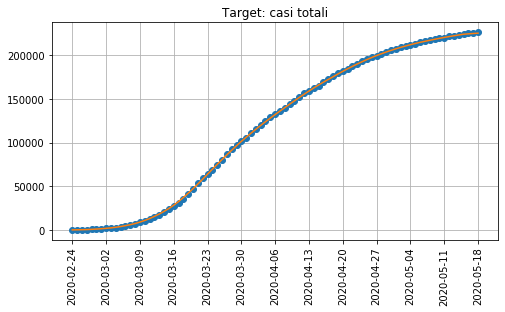

In [5]:
target_data=trend['totale_casi']['Italia']
target_data_filtered=moving_function_rev1(target_data,np.mean,3,3)

fig,ax=plt.subplots(1,1,figsize=(8,4))
ax.plot(day_counter,target_data,'o')
ax.plot(day_counter,target_data_filtered,'-')
ax.set_xticks(list(range(0,len(target_data),7)))
ax.set_title('Target: casi totali')
ax.set_xticklabels(str_giorni[list(range(0,len(target_data),7))],rotation=90)
ax.grid()

## GA-based Curve fitting


In [ ]:
days_training=len(target_data)

# Italia
a_range=[0,0.25]
b_range=[0, 0.1]
c_range=[0,10]
M_range=[2e+5,3e+5]
alpha_range=[0,10]



# dominio per generalized_sigmoid_ext
dominio=np.vstack((a_range,
                   b_range,
                   c_range,
                   M_range,
                   alpha_range))



'''
# dominio per DOUBLE generalized_sigmoid_ext
M_range=[0,3e+5]
dominio=np.vstack((a_range,
                   b_range,
                   c_range,
                   M_range,
                   alpha_range,
                   a_range,
                   b_range,
                   c_range,
                   M_range,
                   alpha_range))
'''
                   
dominio=dominio.T

tabprint(dominio,digits=10,precision=2,index=['Min','Max'])

In [13]:
def error_measure(predicted,actual):
    return np.mean(np.abs(predicted-actual))#+np.std(np.abs(predicted-actual))
    #return np.mean(np.abs(predicted-actual)/actual)
    #return 0.2*np.percentile(np.abs(predicted-actual),97)+np.mean(np.abs(predicted-actual))

np.random.seed(42)
    
fct=FagaCurveFit()

fct.fit(generalized_sigmoid_ext, 
        np.arange(days_training),
        target_data[0:days_training],
        dominio,
        ga_generations=1000, ga_population=100,print_info=100,
        error_function=error_measure,num_mutations='auto')

print('\nOptimal solution is: ')
solution=fct.opt_params
print(solution)

Hello from FagaCurveFit!
Gen:     0 BestAll: 12.81 BestGen: 12.81  BioDiv: 5.8e+03
Gen:   100 BestAll: 42.7 BestGen: 42.7  AveFit: 40.52
Gen:   200 BestAll: 42.87 BestGen: 42.87  AveFit: 39.49
Gen:   300 BestAll: 43 BestGen: 43  AveFit: 41.1
Gen:   400 BestAll: 43.29 BestGen: 43.29  AveFit: 39.68
Gen:   500 BestAll: 43.37 BestGen: 43.37  AveFit: 40.37
Gen:   600 BestAll: 43.37 BestGen: 43.37  AveFit: 40.3
Gen:   700 BestAll: 43.4 BestGen: 43.4  AveFit: 41.2
Gen:   800 BestAll: 43.42 BestGen: 43.42  AveFit: 40.58
Gen:   900 BestAll: 43.52 BestGen: 43.52  AveFit: 41.07
Gen:  1000 BestAll: 43.52 BestGen: 43.52  AveFit: 39.78

Optimal solution is: 
[6.29332916e-02 4.71667092e-02 7.86608954e+00 2.34737401e+05
 8.19403491e+00]


dict_keys(['average', 'max', 'std'])

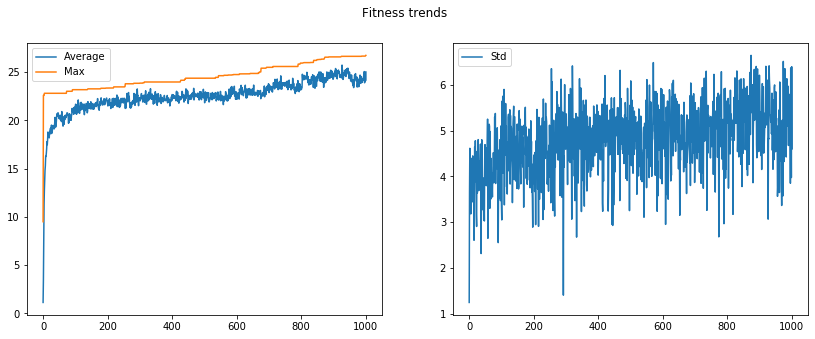

In [8]:
fig,ax=plt.subplots(1,2,figsize=(14,5))
ax[0].plot(fct.fitness_tracker['average'],label='Average')
ax[0].plot(fct.fitness_tracker['max'],label='Max')
ax[0].legend()
ax[1].plot(fct.fitness_tracker['std'],label='Std')
ax[1].legend()
fig.suptitle('Fitness trends')

fct.fitness_tracker.keys()

Adesso applico il modello tunato sia ai giorni passati sia a giorni futuri.

*forecast_days* sono i giorni per cui lo applico: iniziano dal giorno 0 e finoscono quando si vuole nel futuro

In [9]:
forecast_days=np.arange(200)
y_pred=np.array(list(map(lambda x:generalized_sigmoid_ext(x,*solution),forecast_days)))

#### Plots

C:\Users\klaat\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


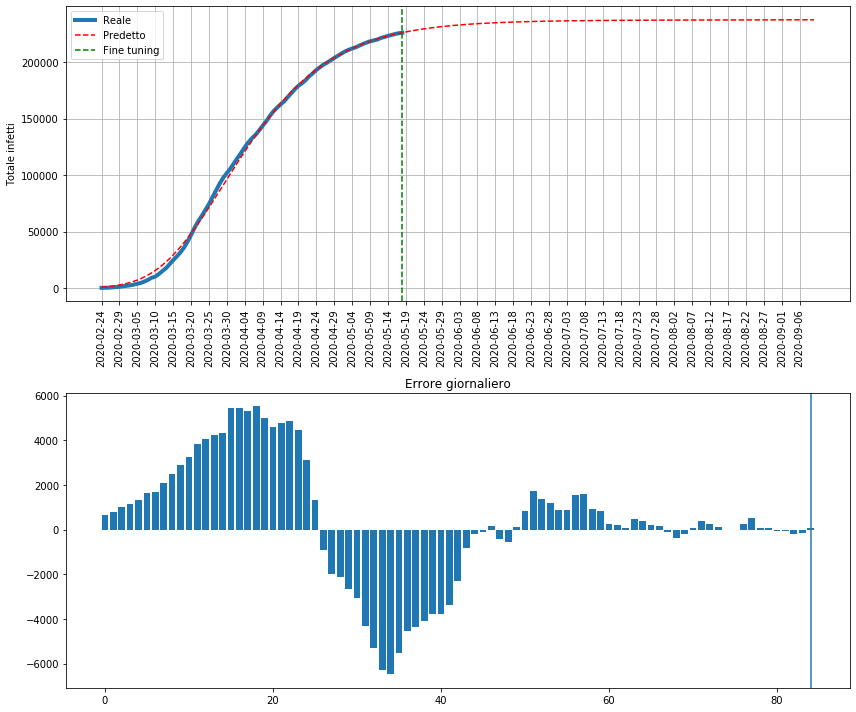

In [10]:
# preparazione palette colori
lista_colori=list(mcolors.TABLEAU_COLORS.items())
color_names=[cn[0] for cn in lista_colori]

fig,ax=plt.subplots(2,1,figsize=(12,10))
ax[0].plot(day_counter,target_data,label='Reale',linewidth=4)
ax[0].plot(forecast_days,y_pred,'r--',label='Predetto')
ax[0].axvline(days_training-1,c='g',ls='--',label='Fine tuning')
ax[0].set_xticks(list(range(0,len(forecast_days),5)))
ax[0].set_xticklabels(str_giorni[list(range(0,len(forecast_days),5))],rotation=90)
ax[0].set_ylabel('Totale infetti')
ax[0].legend()
ax[0].grid()

ax[1].bar(day_counter,y_pred[day_counter]-target_data)
ax[1].axvline(days_training-1)
ax[1].set_title('Errore giornaliero')
fig.tight_layout()
fig.show()

### Adesso vediamo, secondo il modello, quando non avremo più contagiati

In [11]:
nuovi_contagi_pred=np.diff(y_pred)

nuovi_contagi_reali=np.diff(target_data)
nuovi_contagi_reali_filtered=np.diff(target_data_filtered)


soglie_contagi=[1000,500,100,50]
giorni_soglia=[]
for soglia in soglie_contagi:
    nuovi_contagi_sotto_soglia=[i for i,nc in enumerate(nuovi_contagi_pred) if (i>30 and nc<=soglia)]
    giorni_soglia.append(nuovi_contagi_sotto_soglia[0])



Soglia:  1000   Giorno:   77 [2020-05-11]
Soglia:   500   Giorno:   89 [2020-05-23]
Soglia:   100   Giorno:  116 [2020-06-19]
Soglia:    50   Giorno:  128 [2020-07-01]


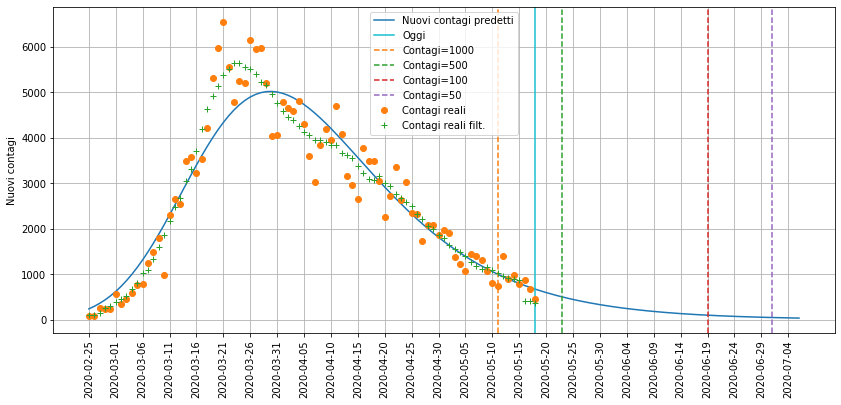

In [12]:
fig,ax=plt.subplots(1,1,figsize=(14,6))
ax.plot(range(max(giorni_soglia)+5),nuovi_contagi_pred[0:max(giorni_soglia)+5],label='Nuovi contagi predetti')
ax.set_ylabel('Nuovi contagi')
ax.axvline(indice_oggi-1,label='Oggi',c=color_names[9])
for i,soglia in enumerate(soglie_contagi):
    ax.axvline(giorni_soglia[i]-1,label='Contagi=%d'%soglia,c=color_names[i+1],linestyle='--')

ax.plot(nuovi_contagi_reali,'o',label='Contagi reali')
ax.plot(nuovi_contagi_reali_filtered,'+',label='Contagi reali filt.')
    
ax.set_xticks(list(range(0,max(giorni_soglia)+5,5)))
ax.set_xticklabels(str_giorni[list(range(1,len(forecast_days),5))],rotation=90)
ax.grid()
ax.legend()

for i,soglia in enumerate(soglie_contagi):
    print('Soglia: %5d   Giorno: %4d [%10s]'%(soglia,giorni_soglia[i],str_giorni[giorni_soglia[i]]))